### tests :

We would like to know why the algorithm calculates a lot of states near the intermediary states. 

Ideas: 
   - plot the fidelity towards the intermediary state. We will have 3 plots in the case where we have 
    3 intermediary states.
    
   - plot $\lambda$ vs time

In this notebook, we are searching a usecase for intermediary states. This mean that we would like to find a trajectory with intermediary states that follows the geodesic in a better way than a continuos trajectory

## Setup 3 with Python code

Without and with intermediary states.
At the end, one will find the plots comparing both results.

In [1]:
# libraries
import numpy as np
import matplotlib as mpl
from matplotlib import cm
#from sympy.solvers import solve
#from sympy import Symbol
#
#from scipy.optimize import minimize
#from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

import qutip

#import mayavi

from contrlWithGeodesics import geodesic

from contrlWithGeodesics import fidelity
from contrlWithGeodesics.pauli_mat_vec import *
from contrlWithGeodesics.utils import delete_less_than_k
from contrlWithGeodesics.controlSetup3 import control1setup3,control1setup3_int_states
from contrlWithGeodesics.getTimeFidelity import get_time_fidelity
#

Control activated and ready to use


In [2]:
## this cell is to have nice plots
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
# test
vect1= np.array([0.0,0.0,0.9])
vect2= np.array([0.9,0.0,0.0])
geodesic(0.5,vect1,vect2)

array([[0.79169168+0.j, 0.29169168+0.j],
       [0.29169168+0.j, 0.20830832+0.j]])

In [4]:
# Test values
#qsri = 1/np.sqrt(3)*np.array([1.0, 1.0, 0.9])
#qssf = np.array([0.0, 0.9, 0.0])
qsri = 1/np.sqrt(3)*np.array([0.7, 0.8, 0.8])
qssf = 1/np.sqrt(3)*np.array([0.2, 0.9, 0.0])
w0 = 5.0
gamma_0 = 0.01
gamma_c = 10
Nmax = 40
imax = 7
deltat = 0.0030

# Save initial and final states
auxri = qsri
auxsf = qssf

In [19]:
## testing cell
estadoslist, tiempolists, solution, vec_lambda = control1setup3(qsri,qssf,Nmax=Nmax,deltat=deltat)
#tiempolists
#vec_lam
vec_lambda

[61.2742005627058,
 66.1754754389770,
 72.2489523163035,
 79.9079104001009,
 89.7922670200548,
 102.939219395469,
 121.118307692969,
 147.492623432852,
 187.666770093428,
 248.164669292313,
 307.972473933609,
 316.921935515036,
 318.252597826855,
 324.880389404821,
 334.780035666073,
 346.905407804125,
 360.883774541796,
 376.584588786629,
 393.971075135170,
 413.053053804751,
 433.871968766903,
 456.496555179561,
 481.022512015951,
 507.574093711271,
 536.306953130847,
 567.412052702351,
 601.120675478032,
 637.710716483165,
 677.514580782044,
 720.929182658713,
 768.428748278504,
 820.581396670479,
 878.070849236814,
 941.725157035246,
 1012.55513465956,
 1091.80640669909,
 1181.03086838413,
 1282.18638206356,
 1397.77846199204,
 1531.06597588228,
 1686.36722789532]

In [16]:
## testing cell

finalestados, finaltiempotot, list_lambda_time=get_time_fidelity(estadoslist,tiempolists,solution,imax,qssf)
###
# take account that the bigger imax the better the fidelity. But the improvement in the fidelity 
# is very small



Find time with fidelity
new time: 0.018047968327896163
Fidelity 0.9996280767710948
New quantum state [0.11727109 0.55114972 0.00840203]
Find time with fidelity
new time: 0.0016597737001460106
Fidelity 0.9996814785020094
New quantum state [ 1.16570695e-01  5.49611327e-01 -2.75592779e-04]
Find time with fidelity
new time: 0.0005512211535933214
Fidelity 0.9997035681662392
New quantum state [0.11583265 0.54833099 0.004832  ]
Find time with fidelity
new time: 0.0059727674612250125
Fidelity 0.9998633758128281
New quantum state [0.12042672 0.5370892  0.00889553]
Find time with fidelity
new time: 0.00031930693308050977
Fidelity 0.9998752930139858
New quantum state [0.11832551 0.53759822 0.00546646]
Find time with fidelity
new time: 0.00040214755225599224
Fidelity 0.999883719487303
New quantum state [0.11693966 0.53762968 0.00233403]
Find time with fidelity
new time: 0.0012789775458270198
Fidelity 0.9999056626468097
New quantum state [0.11562314 0.53511377 0.00647526]


[3550.56786842439,
 2946.82610890936,
 3860.01516112416,
 4120.04048576966,
 6498.11418171858,
 6779.76826883387,
 5181.75109690169]

In [7]:
list(finalestados[30])[1]

0.6390087811231925

In [8]:
list_lambda_time

[3550.56786842439,
 2946.82610890936,
 3860.01516112416,
 4120.04048576966,
 6498.11418171858,
 6779.76826883387,
 5181.75109690169]

In [9]:
# radius
radius = [np.sqrt((finalestados[i][0])**2+(finalestados[i][1])**2+(finalestados[i][2])**2) for i in range(len(finalestados))]
listfidelities=[fidelity(finalestados[i],qssf) for i in range(len(finalestados))]

In [10]:
### plots

### bloch sphere
length = 1
nrm = mpl.colors.Normalize(0,length)
#colors = cm.winter(nrm(range(length))) # options: cool, summer, winter, autumn etc.
colors = cm.winter(range(length)) # options: cool, summer, winter, autumn etc.

b = qutip.Bloch(view=[170,50],figsize=[3,3])
b.sphere_alpha=0.2
b.point_color = ['r'] # options: 'r', 'g', 'b' etc.
b.point_marker = ['o']
b.point_size = [20]
for i in range(len(finalestados)):
    b.add_points(finalestados[i])
    
## ploting geodesic
Numbergeo = 250
geolist = [geodesic(t/Numbergeo,qsri,qssf) for t in range(Numbergeo+1)]
colors2 = cm.cool(nrm(range(length))) # options: cool, summer, winter, autumn etc.

vectorgeo = [bloch_vector(rho) for rho in geolist]
#b.point_color = ['b'] # options: 'r', 'g', 'b' etc.
#b.point_marker = ['*']
#b.point_size = [20]
for i in range(len(vectorgeo)):
    #b.point_color = list(colors2) # options: 'r', 'g', 'b' etc.
    b.add_points(vectorgeo[i])

#b.add_points(auxri)
#b.add_points(auxsf)
newbloch=qutip.Bloch(view=[170,50],figsize=[3,3])
newbloch.point_color = ['b'] # options: 'r', 'g', 'b' etc.
newbloch.point_marker = ['*']
newbloch.point_size = [20]
newbloch.sphere_alpha=0.01
newbloch.frame_alpha=0.01
#newbloch.
for i in range(len(vectorgeo)):
    #b.point_color = list(colors2) # options: 'r', 'g', 'b' etc.

    newbloch.add_points(vectorgeo[i],'s')

In [11]:
#Mayavi is not working
#b3d = qutip.Bloch3d()
#b3d.show()



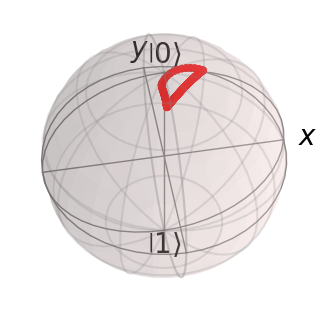

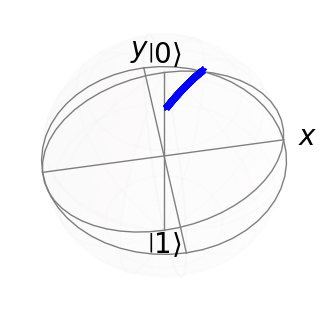

In [12]:
#improve plots

b.show()
newbloch.show()

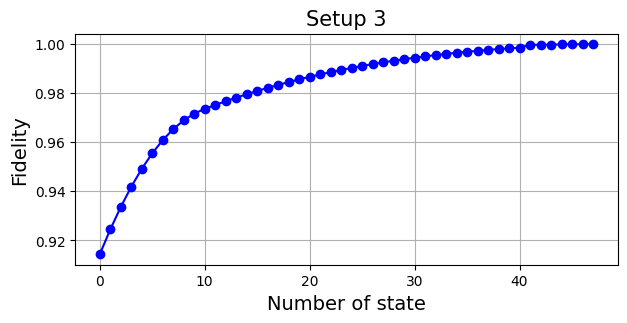

In [13]:
# data
xaxis = [i for i in range(len(finalestados))]

# create a figure and axes
fig, ax = plt.subplots()

# plot the data
ax.plot(xaxis, listfidelities, '-o', color='blue')

# add labels and title
ax.set_xlabel('Number of state',fontsize=14)
ax.set_ylabel('Fidelity',fontsize=14)
ax.set_title('Setup 3',fontsize=15)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(7, 3)

# show the plot
plt.show()

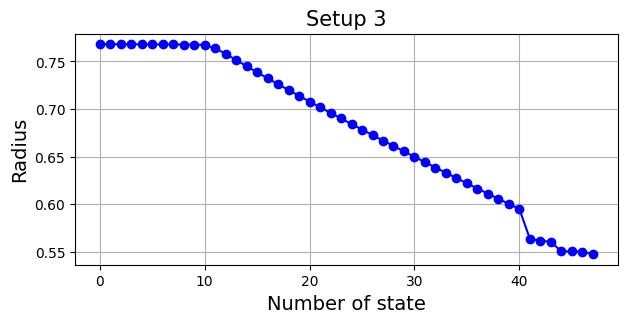

In [14]:
# create a figure and axes
fig, ax = plt.subplots()

# plot the data
ax.plot(xaxis,radius , '-o', color='blue')

# add labels and title
ax.set_xlabel('Number of state',fontsize=14)
ax.set_ylabel('Radius',fontsize=14)
ax.set_title('Setup 3',fontsize=15)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(7, 3)

# show the plot
plt.show()

ValueError: x and y must have same first dimension, but have shapes (48,) and (47,)

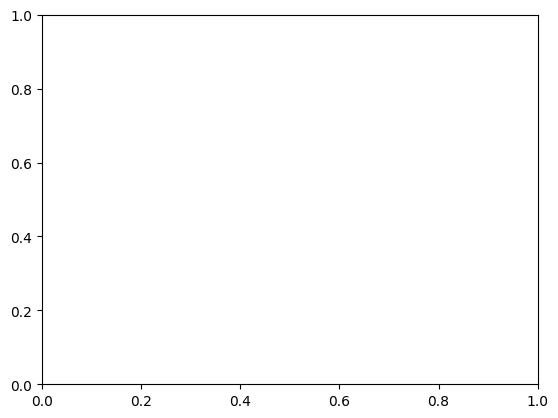

In [15]:
# create a figure and axes
fig, ax = plt.subplots()

# plot the data
ax.plot(xaxis,finaltiempotot, '-o', color='blue')

# add labels and title
ax.set_xlabel('Number of state',fontsize=14)
ax.set_ylabel('total time',fontsize=14)
ax.set_title('Setup 3',fontsize=15)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(7, 4)

# show the plot
plt.show()

In [ ]:
print(list_lambda_time[0:5])
print(vec_lambda[0:10])
len(list_lambda_time)

In [ ]:
list_lambda =  vec_lambda+list_lambda_time
# create a figure and axes
fig, ax = plt.subplots()

# plot the data
ax.plot(xaxis, list_lambda, '-o', color='blue',label="$/lambda$")



#####################

# data without intermediary states
#xaxis1 = [i for i in range(len(finalestados))]
#ax.plot(xaxis1, listfidelities, '-*', color='green',label="Conti")
#########################

# add labels and title
ax.set_xlabel('Number of state',fontsize=14)
ax.set_ylabel('lambda',fontsize=14)
ax.set_title('Setup 3, lambda over time',fontsize=15)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(7, 4)
plt.legend(fontsize=12,loc='lower right')
# show the plot
plt.show()

## Testing with intermediary states

In the following cells we are going to use the geodesic that will give us some intermediary states in order to improve the control methodology

In [ ]:
# Test values
#del(estadoslist, tiempolists, solution)
#qsri = 1/np.sqrt(3)*np.array([1.0, 1.0, 0.9])
#qssf = np.array([0.0, 0.9, 0.0])
qsri = 1/np.sqrt(3)*np.array([0.7, 0.8, 0.8])
qssf = 1/np.sqrt(3)*np.array([0.2, 0.9, 0.0])
w0 = 5

gamma_0 = 0.01
gamma_c = 10
Nmax = 30 ### with 20 is not working
imax = 7
deltat = 0.003

# Save initial and final states
auxri = qsri
auxsf = qssf

In [ ]:
#numinter = 4 #number of intermediary states

numinter = 5 #number of intermediary states

#get the intermediary states from the geodesic
intermediaryqs=[geodesic((i)/(numinter-1),qsri,qssf) for i in range(numinter)]
intermediary = [bloch_vector(intermediaryqs[i]) for i in range(len(intermediaryqs)) ]
k = 1.0e-6
for i in range(numinter):
    delete_less_than_k(intermediary[i],k)

In [ ]:
intermediary

In [ ]:
solestes =[]
soltimes=[]
auxtime = 0.0
list_lambda = list([])
for i in range(numinter-1):
#for i in range(3):
    #print("run",i)
    estadoslist, tiempolists, solution, lambdavec = control1setup3_int_states(qsri,intermediary[i+1],Nmax=Nmax,initime=auxtime)
    #print(estadoslist)
    solestes=solestes+estadoslist
    soltimes=soltimes+tiempolists
    qsri=estadoslist[-1]
    #print(tiempolists[-1])
    auxtime=tiempolists[-1]
    list_lambda=list_lambda+lambdavec

In [ ]:
list_lambda[0:10]

## Using the $i_{max}$ loop and intermediary states

In [ ]:
estadoslist=solestes ## reuse the varaible 
tiempolists = soltimes ## reuse the variable
solestes, soltimes, vec_lambda_time=get_time_fidelity(estadoslist,tiempolists,solution,imax,qssf)
list_lambda = list_lambda + vec_lambda_time

In [ ]:
list_lambda

In [ ]:
### for plots using intermediary states

# radius and fidelities
radiusint = [np.sqrt((solestes[i][0])**2+(solestes[i][1])**2+(solestes[i][2])**2) for i in range(len(solestes))]
listfidelitiesint=[fidelity(solestes[i],qssf) for i in range(len(solestes))]

In [ ]:
### fidelity using intermediary states

fide_inter_1 = [fidelity(solestes[i],intermediary[1]) for i in range(len(solestes))]
fide_inter_2 = [fidelity(solestes[i],intermediary[2]) for i in range(len(solestes))]
fide_inter_3 = [fidelity(solestes[i],intermediary[3]) for i in range(len(solestes))]

## Plots using intermediary states and setup 3

In [ ]:
### plots

### bloch sphere
length = 1
nrm = mpl.colors.Normalize(0,length)
#colors = cm.winter(nrm(range(length))) # options: cool, summer, winter, autumn etc.
colors = cm.winter(range(length)) # options: cool, summer, winter, autumn etc.

b = qutip.Bloch(view=[170,10],figsize=[3,3])
b.sphere_alpha=0.2
b.point_color = ['r'] # options: 'r', 'g', 'b' etc.
b.point_marker = ['o']
b.point_size = [20]
for i in range(len(solestes)):
    b.add_points(solestes[i])
    
## ploting geodesic
Numbergeo = 250
geolist = [geodesic(t/Numbergeo,auxri,qssf) for t in range(Numbergeo+1)]
colors2 = cm.cool(nrm(range(length))) # options: cool, summer, winter, autumn etc.

vectorgeo = [bloch_vector(rho) for rho in geolist]
#b.point_color = ['b'] # options: 'r', 'g', 'b' etc.
#b.point_marker = ['*']
#b.point_size = [20]
#for i in range(len(vectorgeo)):
    #b.point_color = list(colors2) # options: 'r', 'g', 'b' etc.
#    b.add_points(vectorgeo[i])

#b.add_points(auxri)
#b.add_points(auxsf)
newbloch=qutip.Bloch(view=[170,30],figsize=[3,3])
newbloch.point_color = ['b'] # options: 'r', 'g', 'b' etc.
newbloch.point_marker = ['*']
newbloch.point_size = [20]
newbloch.sphere_alpha=0.01
newbloch.frame_alpha=0.01
#newbloch.
for i in range(len(vectorgeo)):
    #b.point_color = list(colors2) # options: 'r', 'g', 'b' etc.
    newbloch.add_points(vectorgeo[i],'s')

In [ ]:
#improve plots
b.show()
newbloch.show()

In [ ]:
# data
xaxis = [i for i in range(len(solestes))]

# create a figure and axes
fig, ax = plt.subplots()

# plot the data
ax.plot(xaxis, listfidelitiesint, '-o', color='blue',label="Inter")

#####################

# data without intermediary states
xaxis1 = [i for i in range(len(finalestados))]
ax.plot(xaxis1, listfidelities, '-*', color='green',label="Conti")
#########################

# add labels and title
ax.set_xlabel('Number of state',fontsize=14)
ax.set_ylabel('Fidelity',fontsize=14)
ax.set_title('Setup 3',fontsize=15)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(7, 4)
plt.legend(fontsize=12,loc='lower right')
# show the plot
plt.show()

In [ ]:
# create a figure and axes
fig, ax = plt.subplots()

# plot the data
ax.plot(xaxis,radiusint, '-o', color='blue',label="Inter")
ax.plot(xaxis1, radius, '-*', color='green',label="Conti")

# add labels and title
ax.set_xlabel('Number of state',fontsize=14)
ax.set_ylabel('Radius',fontsize=14)
ax.set_title('Setup 3',fontsize=15)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(7, 4)
plt.legend(fontsize=12,loc='lower left')
# show the plot
plt.show()

In [ ]:
# create a figure and axes
fig, ax = plt.subplots()

# plot the data
ax.plot(xaxis,soltimes, '-o', color='blue',label="Inter")
ax.plot(xaxis1,finaltiempotot, '-o', color='green',label="Conti")

# add labels and title
ax.set_xlabel('Number of state',fontsize=14)
ax.set_ylabel('total time',fontsize=14)
ax.set_title('Setup 3',fontsize=15)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(7, 4)
plt.legend(fontsize=12,loc='lower right')
# show the plot
plt.show()

In [ ]:
# data
xaxis = [i for i in range(len(solestes))]

# create a figure and axes
fig, ax = plt.subplots()

# plot the data
ax.plot(xaxis, fide_inter_1, '-o', color='blue',label="Inter1")
ax.plot(xaxis, fide_inter_2, '-o', color='green',label="Inter2")
ax.plot(xaxis, fide_inter_3, '-o', color='black',label="Inter3")


#####################

# data without intermediary states
#xaxis1 = [i for i in range(len(finalestados))]
#ax.plot(xaxis1, listfidelities, '-*', color='green',label="Conti")
#########################

# add labels and title
ax.set_xlabel('Number of state',fontsize=14)
ax.set_ylabel('Fidelity',fontsize=14)
ax.set_title('Setup 3, fidelity over time',fontsize=15)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(7, 4)
plt.legend(fontsize=12,loc='lower right')
# show the plot
plt.show()

In [ ]:
# data
xaxis = [i for i in range(len(solestes))]

# create a figure and axes
fig, ax = plt.subplots()

# plot the data
ax.plot(xaxis, list_lambda, '-o', color='blue',label="$/lambda$")



#####################

# data without intermediary states
#xaxis1 = [i for i in range(len(finalestados))]
#ax.plot(xaxis1, listfidelities, '-*', color='green',label="Conti")
#########################

# add labels and title
ax.set_xlabel('Number of state',fontsize=14)
ax.set_ylabel('lambda',fontsize=14)
ax.set_title('Setup 3, lambda over time',fontsize=15)
plt.grid()
fig = plt.gcf()
fig.set_size_inches(7, 4)
plt.legend(fontsize=12,loc='lower right')
# show the plot
plt.show()

In [ ]:
list_lambda